In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler , StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import logging #def get_air_passengers
import random
#encoder
from tensorflow import keras
from keras.layers import GRU, LSTM, Conv1D, Dense, Dropout, Embedding, LayerNormalization, TimeDistributed,RepeatVector

from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras import backend as K

import os
import random

from sklearn.metrics import mean_absolute_error

#from kerashypetune import KerasGridSearch


from keras import Input, models, layers, losses
from keras.models import Sequential, Model

from keras.callbacks import EarlyStopping

from keras.layers import Lambda
from keras import backend as K


# pos

In [ ]:
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding

    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size

    Returns:
        angles -- (pos, d) numpy array
    """

    # Get i from dimension span k
    i = k // 2
    # Calculate the angles using pos, i and d
    angles = pos / np.power(10000, 2 * i / d)


    return angles



def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings

    Arguments:
        positions (int) -- Maximum number of positions to be encoded
        d (int) -- Encoding size

    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """

    # initialize a matrix angle_rads of all the angles
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
                            np.arange(d)[np.newaxis, :],
                            d)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])


    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

# **enc**

In [ ]:
import tensorflow as tf

def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'), # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim) # (batch_size, seq_len, d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network.
    This archirecture includes a residual connection around each of the two
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate, layernorm_eps):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)
        self.dropout_mha = Dropout(dropout_rate)
        self.dropout_layernorm1 = Dropout(dropout_rate)
        self.dropout_layernorm2 = Dropout(dropout_rate)


    def call(self, x, training, mask=None):
        """
        Forward pass for the Encoder Layer

        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not
                    treated as part of the input
        Returns:
            encoder_layer_out -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
        """
        # self-attention using mha. Dropout will be applied during training
        attn_output = self.mha(x, x, x, mask) # Self attention (batch_size, input_seq_len, fully_connected_dim)
        attn_output=self.dropout_mha(attn_output, training = training)
        # layer normalization on sum of the input and the attention output to get the
        # output of the multi-head attention layer
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, fully_connected_dim)
        out1=self.dropout_layernorm1(out1, training = training)
        # pass the output of the multi-head attention layer through a ffn
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, fully_connected_dim)

        # apply dropout layer to ffn output during training
        ffn_output =  self.dropout_ffn(ffn_output, training=training)

        # apply layer normalization on sum of the output from multi-head attention and ffn output to get the
        # output of the encoder layer
        encoder_layer_out = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, fully_connected_dim)
        encoder_layer_out= self.dropout_layernorm2(encoder_layer_out, training = training)

        return encoder_layer_out

# **dec**

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks,
    one that takes the new input and uses self-attention, and the other
    one that combines it with the output of the encoder, followed by a
    fully connected block.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate, layernorm_eps):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)
        self.dropout_mha1 = Dropout(dropout_rate)
        self.dropout_mha2 = Dropout(dropout_rate)
        self.dropout_layernorm1 = Dropout(dropout_rate)
        self.dropout_layernorm2 = Dropout(dropout_rate)
        self.dropout_layernorm3 = Dropout(dropout_rate)


    def call(self, x, enc_output, src_mask, tgt_mask, training):
        """
        Forward pass for the Decoder Layer

        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer

        """

        # enc_output.shape == (batch_size, input_seq_len, fully_connected_dim)

        # BLOCK 1
        #self-attention and return attention scores as attn_weights_block1.
        # Dropout will be applied during training
        mult_attn_out1, attn_weights_block1 = self.mha1(x, x, x, tgt_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        mult_attn_out1=self.dropout_mha1(mult_attn_out1, training = training)
        # layer normalization (layernorm1) to the sum of the attention output and the input
        Q1 = self.layernorm1(mult_attn_out1 + x)
        Q1=self.dropout_layernorm1(Q1, training = training)

        # BLOCK 2
        # self-attention using the Q from the first block and K and V from the encoder output.
        # Dropout will be applied during training
        # Return attention scores as attn_weights_block2
        mult_attn_out2, attn_weights_block2 = self.mha2(Q1, enc_output, enc_output, src_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        mult_attn_out2= self.dropout_mha2(mult_attn_out2, training = training)
        # apply layer normalization (layernorm2) to the sum of the attention output and the output of the first block
        mult_attn_out2 = self.layernorm2(mult_attn_out2 + Q1)  # (batch_size, target_seq_len, fully_connected_dim)
        mult_attn_out2 = self.dropout_layernorm2(mult_attn_out2, training = training)

        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(mult_attn_out2)  # (batch_size, target_seq_len, fully_connected_dim)

        # apply a dropout layer to the ffn output
        ffn_output = self.dropout_ffn(ffn_output, training = training)

        # apply layer normalization (layernorm3) to the sum of the ffn output and the output of the second block
        out3 = self.layernorm3(ffn_output + mult_attn_out2)  # (batch_size, target_seq_len, fully_connected_dim)
        out3= self.dropout_layernorm3(out3, training = training)

        return out3

# Data Processing

In [ ]:
df=pd.read_csv("univar.csv" )
df['date'] = pd.to_datetime(df['date'])
df=df.set_index(df['date'], drop=False, append=False, inplace=False, verify_integrity=False).drop('date', 1)



train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size
train_data, val_data, test_data = df.iloc[:train_size], df.iloc[train_size:train_size+val_size], df.iloc[train_size+val_size:]

# 3. Apply MinMax scaling to each part
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)


# Print the shapes of the resulting datasets
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (15788, 1)
Validation data shape: (1973, 1)
Test data shape: (1974, 1)


<ipython-input-51-254a59cc3177>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df=df.set_index(df['date'], drop=False, append=False, inplace=False, verify_integrity=False).drop('date', 1)


In [ ]:
import numpy as np

# Define sequence length parameters

enc_seq_len = 24
dec_seq_len = 2
seq_len= enc_seq_len + dec_seq_len

# Generate some mock data
data = train_data

# Define sliding window indices
indices = [(i, i+seq_len) for i in range(len(data)-seq_len+1)]

# Define function to generate source and target sequences from a window
def get_src_trg(window):
    # Extract encoder input and decoder input/target sequences
    src = window[:enc_seq_len]
    trg = window[enc_seq_len-1:enc_seq_len+dec_seq_len-1]
    trg_y = window[enc_seq_len:enc_seq_len+dec_seq_len]
    return src, trg, trg_y

# Generate dataset by applying sliding window and extracting source/target sequences
dataset = [get_src_trg(data[start:end]) for start, end in indices]

# Convert dataset to tensors
src = tf.stack([item[0] for item in dataset])
trg = tf.stack([item[1] for item in dataset])
trg_y = tf.stack([item[2] for item in dataset])

# Print shapes of output tensors
print("src shape:", src.shape)
print("trg shape:", trg.shape)
print("trg_y shape:", trg_y.shape)

src shape: (15763, 24, 1)
trg shape: (15763, 2, 1)
trg_y shape: (15763, 2, 1)


In [ ]:
trg_y[:1]

<tf.Tensor: shape=(1, 2, 1), dtype=float64, numpy=
array([[[0.09345794],
        [0.09345794]]])>

In [ ]:
trg[:1]

<tf.Tensor: shape=(1, 2, 1), dtype=float64, numpy=
array([[[0.09345794],
        [0.09345794]]])>

In [ ]:

# Define sliding window indices
indices = [(i, i+seq_len) for i in range(len(val_data)-seq_len+1)]

# Define function to generate source and target sequences from a window
def get_src_trg(window):
    # Extract encoder input and decoder input/target sequences
    src = window[:enc_seq_len]
    trg = window[enc_seq_len-1:enc_seq_len+dec_seq_len-1]
    trg_y = window[enc_seq_len:enc_seq_len+dec_seq_len]
    return src, trg, trg_y

# Generate dataset by applying sliding window and extracting source/target sequences
dataset = [get_src_trg(val_data[start:end]) for start, end in indices]

# Convert dataset to tensors
src_val = tf.stack([item[0] for item in dataset])
trg_val = tf.stack([item[1] for item in dataset])
trg_y_val = tf.stack([item[2] for item in dataset])

# Print shapes of output tensors
print("src_val shape:", src_val.shape)
print("trg_val shape:", trg_val.shape)
print("trg_y_val shape:", trg_y_val.shape)

src_val shape: (1948, 24, 1)
trg_val shape: (1948, 2, 1)
trg_y_val shape: (1948, 2, 1)


In [ ]:


# Define sliding window indices
indices = [(i, i+seq_len) for i in range(len(test_data)-seq_len+1)]

# Define function to generate source and target sequences from a window
def get_src_trg(window):
    # Extract encoder input and decoder input/target sequences
    src = window[:enc_seq_len]
    trg = window[enc_seq_len-1:enc_seq_len+dec_seq_len-1]
    trg_y = window[enc_seq_len:enc_seq_len+dec_seq_len]
    return src, trg, trg_y

# Generate dataset by applying sliding window and extracting source/target sequences
dataset = [get_src_trg(test_data[start:end]) for start, end in indices]

# Convert dataset to tensors
src_test = tf.stack([item[0] for item in dataset])
trg_test = tf.stack([item[1] for item in dataset])
trg_y_test = tf.stack([item[2] for item in dataset])

# Print shapes of output tensors
print("src_test shape:", src_test.shape)
print("trg_test shape:", trg_test.shape)
print("trg_y_test shape:", trg_y_test.shape)

src_test shape: (1949, 24, 1)
trg_test shape: (1949, 2, 1)
trg_y_test shape: (1949, 2, 1)


# Model

In [ ]:

def generate_square_subsequent_mask(dim1: int, dim2: int) -> tf.Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.

    Args:
        dim1: int, for both src and tgt masking, this must be target sequence length
        dim2: int, for src masking this must be encoder sequence length (i.e.
              the length of the input sequence to the model),
              and for tgt masking, this must be target sequence length

    Return:
        A Tensor of shape [dim1, dim2]
    """
    mask = tf.linalg.band_part(tf.ones((dim1, dim2)), -1, 0)
    return (1 - mask) * -1e9

In [ ]:
embedding_dim=8
num_heads=1
fully_connected_dim=16
num_layers=1
input_size=src.shape[2]

input_seq_len = 24
output_seq_len = 2
max_pos_enc=input_seq_len
max_pos_dec=output_seq_len

num_predicted_features=1

dropout_rate=0.2
layernorm_eps=1e-6



input_a = tf.keras.layers.Input(shape=(src.shape[1],src.shape[2]), dtype=tf.float32)
input_b = tf.keras.layers.Input(shape=(trg.shape[1],trg.shape[2]), dtype=tf.float32)

src_mask = generate_square_subsequent_mask(
    dim1=output_seq_len,
    dim2=input_seq_len
    )

# Make tgt mask for decoder with size:
# [batch_size*n_heads, output_sequence_length, output_sequence_length]
tgt_mask = generate_square_subsequent_mask(
    dim1=output_seq_len,
    dim2=output_seq_len
    )

encoders = []
for i in range(num_layers):
    encoders.append(EncoderLayer(embedding_dim=embedding_dim,
                                  num_heads=num_heads,
                                  fully_connected_dim=fully_connected_dim,
                                 dropout_rate=dropout_rate, layernorm_eps=layernorm_eps))


decoders = []
for i in range(num_layers):
    decoders.append(DecoderLayer(embedding_dim=embedding_dim,
                                  num_heads=num_heads,
                                  fully_connected_dim=fully_connected_dim,
                                 dropout_rate=dropout_rate, layernorm_eps=layernorm_eps))

###################################################################################
#encoder_block
encoder_input_layer = tf.keras.layers.Dense(
                          units=embedding_dim,
                          input_shape=(input_size,)
                      )
enco_input=encoder_input_layer(input_a)
enc_pos=positional_encoding(positions=max_pos_enc, d=embedding_dim)
encoder_input = tf.keras.layers.Add()([enco_input, enc_pos])
dropout_enc=Dropout(dropout_rate)(encoder_input)
# # Apply the EncoderLayers to the inputs
enc_output = dropout_enc  # Initialize the output variable
for encoder in encoders:
    enc_output = encoder(enc_output)



#decoder_block
decoder_input_layer = tf.keras.layers.Dense(
                          units=embedding_dim,
                          input_shape=(num_predicted_features,)
                      )

deco_in=decoder_input_layer(input_b)
dec_pos=positional_encoding(positions=max_pos_dec,d=embedding_dim)
decoder_input = tf.keras.layers.Add()([deco_in, dec_pos])
dropout_dec=Dropout(dropout_rate)(decoder_input)






# Apply the DecoderLayers to the inputs
dec_output = dropout_dec  # Initialize the output variable
for decoder in decoders:
    dec_output = decoder(dec_output, enc_output,src_mask, tgt_mask)


linear_mapping = tf.keras.layers.Dense(
                     units=num_predicted_features,
                     input_shape=(embedding_dim,)
                 )

y= linear_mapping(dec_output)

###################################################################################


transformer=Model([input_a,input_b],y,name="Transformer")
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

transformer.compile(optimizer=optimizer, loss='mean_squared_error')
callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]


#transformer.summary()

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(transformer, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:

history = transformer.fit([src, trg], trg_y,
                          validation_data=([src_val,trg_val],trg_y_val ) ,
                           epochs=10, batch_size=32,
                         callbacks=callbacks
                          )

Epoch 1/10
493/493 [==============================] - 12s 13ms/step - loss: 0.1215 - val_loss: 0.0059
Epoch 2/10
493/493 [==============================] - 5s 11ms/step - loss: 0.0117 - val_loss: 0.0060
Epoch 3/10
493/493 [==============================] - 5s 10ms/step - loss: 0.0099 - val_loss: 0.0060
Epoch 4/10
493/493 [==============================] - 6s 13ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 5/10
493/493 [==============================] - 5s 10ms/step - loss: 0.0079 - val_loss: 0.0036
Epoch 6/10
493/493 [==============================] - 6s 13ms/step - loss: 0.0065 - val_loss: 0.0037
Epoch 7/10
493/493 [==============================] - 5s 10ms/step - loss: 0.0061 - val_loss: 0.0036
Epoch 8/10
493/493 [==============================] - 6s 12ms/step - loss: 0.0059 - val_loss: 0.0035
Epoch 9/10
493/493 [==============================] - 5s 11ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 10/10
493/493 [==============================] - 5s 10ms/step - loss: 0.0057 - val_l

In [ ]:
# Evaluate the model on the test data
test_loss = transformer.evaluate([src_test, trg_test], trg_y_test, verbose=0)

print("Test loss:", test_loss)

Test loss: 0.003961972426623106


dict_keys(['loss', 'val_loss'])


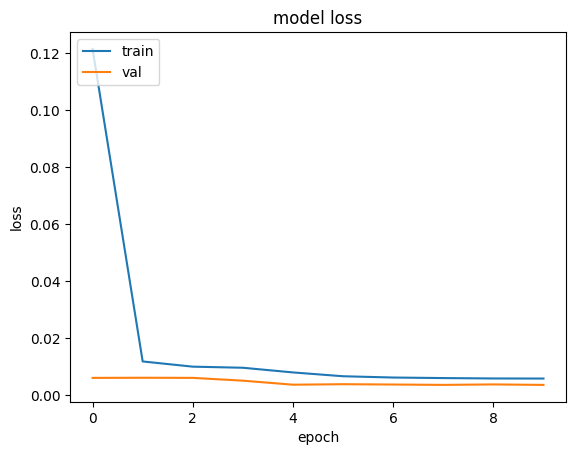

In [ ]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
test_pred = transformer.predict([src_test, trg_test])

85/85 [==============================] - 1s 4ms/step


In [ ]:
test_pred = np.squeeze(test_pred, axis=2) # Remove the extra dimension from test_pred
test_pred = t_transformer.inverse_transform(test_pred)

In [ ]:
test_y2 = np.squeeze(trg_y_test , axis=2) # Remove the extra dimension from test_pred
test_actual = t_transformer.inverse_transform(test_y2)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
# Calculate evaluation metrics
mse = mean_squared_error(test_actual, test_pred)
mae = mean_absolute_error(test_actual, test_pred)
mape = mean_absolute_percentage_error(test_actual, test_pred) * 100
r2 = r2_score(test_actual, test_pred)

# Print evaluation metrics
print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)
print("R-squared:", r2)

MSE: 21885.75985826327
MAE: 115.50927871596365
MAPE: 4.869799339069618
R-squared: 0.9161055325539893


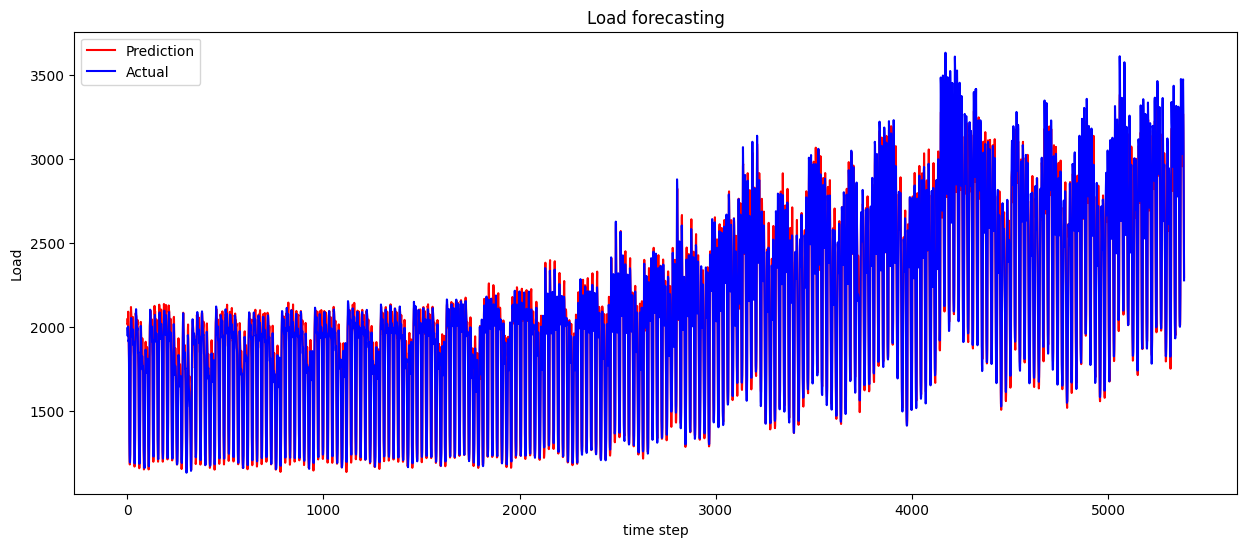

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(test_pred,color='red', label="Prediction" )
plt.plot(test_actual,color='blue', label="Actual")
plt.legend()
plt.ylabel('Load')
plt.xlabel('time step' )
#plt.title ("Russell 2000 Adj close Price prediction- with MAE {:10.4f}".format(mae))
plt.title ('Load forecasting')
plt.show()

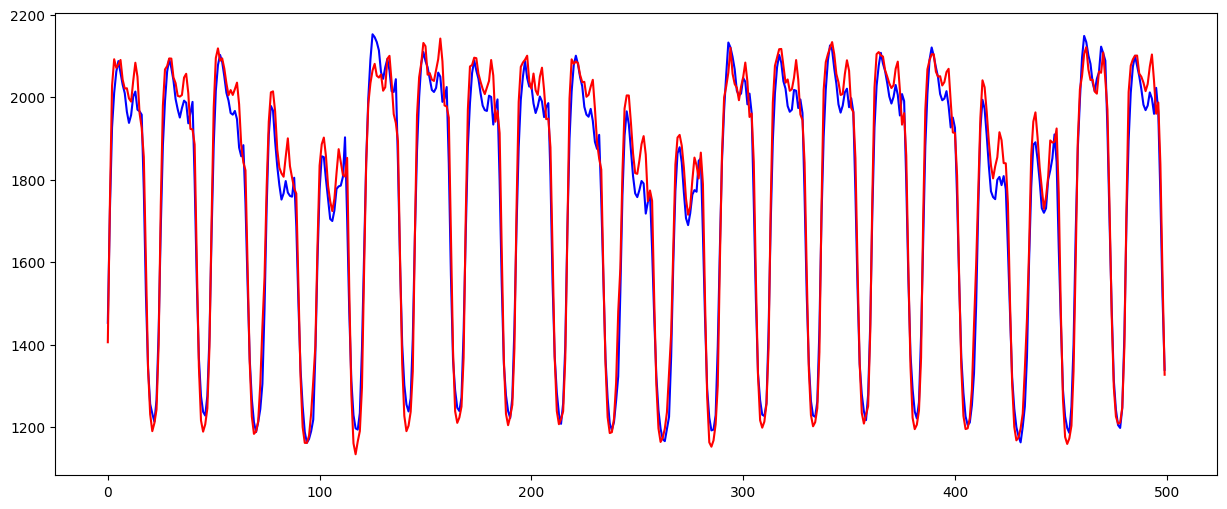

In [ ]:


#zoom in spikes


plt.figure(figsize=(15,6))

plt.plot(test_actual[1000:1500],color='blue' )
plt.plot(test_pred[1000:1500], color='red')
plt.show()

